**분석개요**

    A. 가볼래터 성과 분석 리포트
        1. 매체별 유입 분석
            1) 유입
            2) 재방문
            3) 구독 전환
            4) 이상 유저
            5) 앱설치
            6) 활성
            7) 리텐션
        2. 이동 경로 분석

In [1]:
# basic
import gc
import os
import sys
import warnings
warnings.filterwarnings(action='ignore') 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#--------------------#
# handling
#--------------------#
import math
import time
import random
# import openpyxl
import importlib
import xlsxwriter
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import difflib

#--------------------#
# Vis
#--------------------#
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
## Vis for jupyter theme
from IPython.display import Image
from jupyterthemes import jtplot
jtplot.style(theme= 'grade3', context='notebook', ticks=True, grid=False) ## dark backgroud jupyter notebook theme
# plt.style.use(['seaborn-white']) ## dark background style ## white style : 'seaborn-white'
plt.style.use(['dark_background']) ## dark background style ## white style : 'seaborn-white'
## Vis for korean 
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
fprop = fm.FontProperties(fname=font_location)
font_name = fprop.get_name()
matplotlib.rc('font', family=font_name)

In [2]:
#--------------------#
# sphere package
#--------------------#
sys.path.append("/home/das_share/sphere_class/")
import SpherePackage
from SpherePackage import *
for pkg in [SpherePackage] :
    _ = importlib.reload(pkg)

#--------------------#
# kto package
#--------------------#
sys.path.append("../src/")
import kto_config
import kto_util
import kto_prep
from kto_config import *
from kto_prep import *
from kto_util import *
from DataAnomalyDetection import *
from ReturnToSeq import *
from EventEngineering import *
from JaccardFilltering import *
from CDJ_main import *

for pkg in [kto_config, kto_prep, kto_util] :
    _ = importlib.reload(pkg)

# 1.Data Import

In [23]:
## searchmain & userid prep & pickling
def kto_user_id_prep(x):
    if isinstance(x, str) :
        if x[-2:] in [',N', ',Y'] : return x[:-2]
        else : return x
    else : return x


def preprocess_events(_event, df_target, have_params = False):
    ###################################
    # df_target : default -> df_app_log
    ###################################
    ## 1) userid prep
    df_target[KEY_ID_USER] = df_target[KEY_ID_USER].apply(lambda x : kto_user_id_prep(x))

    ## 2) searchmain prep
    ### create abs_events
    df_target['abs_events'] = df_target['events'].apply(lambda x : DataImport.abstract_events(x))

    ### target data setting
    df_target_prep = df_target[
                df_target['abs_events'].apply(
                    lambda x: True if _event in x else False)]

    dict_events_save = {}    

    ### append events(should be saved) at list by option = have_params
    #### have_params: event에서 params가 비어있으면 지우는 옵션 => True이면 params가 있음을, False는 params가 없음을 의미
    if have_params == False:
        for i in list(df_target_prep.index):
            dict_events_save[i] = []
            for x in df_target_prep['events'][i]:
                if x['name'] != _event:
                    dict_events_save[i].append(x)
                else:
                    pass
    
    else:
        for i in list(df_target_prep.index):
            dict_events_save[i] = []
            for x in df_target_prep['events'][i]:
                if bool(x['params']) == True:
                    dict_events_save[i].append(x)
                else:
                    pass

    ### merge 'events' column with df_target
    df_output = df_target.reset_index()
    df_output['events'] = df_output[['index', 'events']].apply(
        lambda x : dict_events_save[x['index']] 
        if x['index'] in dict_events_save.keys() 
        else x['events'], 
        axis =1)

    ### make abs_events again
    df_output = df_output.drop(columns = 'abs_events', axis = 1)
    df_output['abs_events'] = df_output['events'].apply(lambda x : DataImport.abstract_events(x))
    df_output = df_output.set_index('index')

    return df_output

In [55]:
def return_pickle_file(_input_path, _lst):
    # _lst = []
    # _today = datetime.strptime(e_date, '%Y%m%d') # today = datetime(2021,5,6)
    # dates = (datetime.strptime(e_date, '%Y%m%d') - datetime.strptime(s_date, '%Y%m%d')).days + 1 

    # for i in range(1, dates):
    #     _d = _today - timedelta(days=i) # 설정한 today를 기준으로 과거 n일 json
    #     y = str(_d.year)
    #     m = str(_d.month).zfill(2)
    #     d = str(_d.day).zfill(2)
    #     _d = y+m+d
    #     _lst.append(_d)

    for _date in _lst:
        _date_prep = datetime.strptime(_date, '%Y%m%d')

        df_app_log = DataImport.read_files(
                    input_path = INPUT_PATH + DATA_TYPE + APP_KEY, 
                    today = _date_prep + timedelta(days = 1), 
                    dates = 1,
                    platform_total = True, reduce_memory = True, verbose = False)
        
        df_app_log_prep = preprocess_events(
                            _event = 'searchMain', df_target = df_app_log)

        df_app_log_prep.to_pickle(_input_path+'/'+f'{_date}')


def check_date_return_pickle(e_date):
        lst_json_date_x = []
        lst_json_date_o = []
        lst_pickle_date_o = []
        lst_pickle_date_x = []

        lst_date = []
        today = datetime.strptime(e_date, '%Y%m%d') + timedelta(days = 1) 
        dates = (datetime.strptime(e_date, '%Y%m%d') - datetime.strptime(s_date, '%Y%m%d')).days + 1 

        for i in range(1, dates):
            date = today - timedelta(days=i) # 설정한 today를 기준으로 과거 n일 json
            y = str(date.year)
            m = str(date.month).zfill(2)
            d = str(date.day).zfill(2)
            _date = y+m+d
            lst_date.append(_date)
        
        for p_date in lst_date:
            ## data setting
            j_date = p_date[2:]
            j_input_path = INPUT_PATH + DATA_TYPE + APP_KEY

            ## 세 플랫폼에 모두 json 파일이 존재하지 않는다면 lst_json_date_x에 해당 일자 추가
            if (os.path.isfile(j_input_path + 'ios/' + j_date)==False)&\
            (os.path.isfile(j_input_path + 'android/' + j_date)==False)&\
            (os.path.isfile(j_input_path + 'web/' + j_date)):
                lst_json_date_x.append(j_date)
            
            ## 한 플랫폼에라도 json 파일 존재할 경우 lst_json_date_o에 해당 일자 추가
            else:
                lst_json_date_o.append(j_date)

            ## pickle 파일 없는 경우 lst_pickle_date_x에 일자 추가
            if (os.path.isfile(input_path + '/' + p_date)==False):
                lst_pickle_date_x.append(p_date)
                # lst_pickle_date_o = list(set(lst_date_copy) - set([p_date]))

            ## pickle 파일 있는 경우 lst_pickle_date_o에 일자 추가
            else:
                lst_pickle_date_o.append(p_date)

        return_pickle_file(input_path, _lst = lst_date)

In [68]:
def read_pickle(s_date, e_date, input_path = input_path):
    lst = []
    df_list = []
    _today = datetime.strptime(e_date, '%Y%m%d') + timedelta(days = 1) 
    dates = (datetime.strptime(e_date, '%Y%m%d') - datetime.strptime(s_date, '%Y%m%d')).days + 1 

    for i in range(1, dates+1):
        _d = _today - timedelta(days=i) # 설정한 today를 기준으로 과거 n일 json
        y = str(_d.year)
        m = str(_d.month).zfill(2)
        d = str(_d.day).zfill(2)
        _d = y+m+d
        lst.append(_d)

        df = pd.read_pickle(input_path + '/' + _d)
        df_list.append(df)
    
    df_total = pd.concat(df_list).reset_index(drop = True)

    return df_total

In [69]:
df_total = read_pickle('20221106', '20221112')
df_total

,date,duration,sid,seq,app_key,sphere_id,user_id,uid,adid,gender,birth_y,user_grade,created_date,events,referrer,install_referrer,session,abs_events
0,2022-11-12 00:13:27,9595,hnlyb36BR2WTrfVbDnoDJQ,103,qsJfZhE2Ft85SvZoXInoo3,eLTfEkTeR11YXMl5Q4IcZd5MZ0NC9,,MVR3tF8pQu2aZH1dSK2vCg,49324e34-eec6-4b4a-b27a-a9a87ad2e11f,,0,,2022-08-13 10:04:50,"[{'name': 'homeTopBanner', 'timestamp': 166817...",[],[],"{'device': {'brand': 'Xiaomi'}, 'ip': '182.224...",[homeTopBanner]
1,2022-11-12 00:13:37,97115,hnlyb36BR2WTrfVbDnoDJQ,104,qsJfZhE2Ft85SvZoXInoo3,eLTfEkTeR11YXMl5Q4IcZd5MZ0NC9,,MVR3tF8pQu2aZH1dSK2vCg,49324e34-eec6-4b4a-b27a-a9a87ad2e11f,,0,,2022-08-13 10:04:50,"[{'name': 'sapContentDetail', 'timestamp': 166...",[],[],"{'device': {'brand': 'Xiaomi'}, 'ip': '182.224...",[sapContentDetail]
2,2022-11-12 00:15:14,980,hnlyb36BR2WTrfVbDnoDJQ,105,qsJfZhE2Ft85SvZoXInoo3,eLTfEkTeR11YXMl5Q4IcZd5MZ0NC9,,MVR3tF8pQu2aZH1dSK2vCg,49324e34-eec6-4b4a-b27a-a9a87ad2e11f,,0,,2022-08-13 10:04:50,"[{'name': 'sapHome', 'timestamp': 166817971474...",[],[],"{'device': {'brand': 'Xiaomi'}, 'ip': '182.224...",[sapHome]
3,2022-11-12 00:15:15,10080,hnlyb36BR2WTrfVbDnoDJQ,106,qsJfZhE2Ft85SvZoXInoo3,eLTfEkTeR11YXMl5Q4IcZd5MZ0NC9,,MVR3tF8pQu2aZH1dSK2vCg,49324e34-eec6-4b4a-b27a-a9a87ad2e11f,,0,,2022-08-13 10:04:50,"[{'name': 'homeTopBanner', 'timestamp': 166817...",[],[],"{'device': {'brand': 'Xiaomi'}, 'ip': '182.224...",[homeTopBanner]
4,2022-11-12 00:15:25,62013,hnlyb36BR2WTrfVbDnoDJQ,107,qsJfZhE2Ft85SvZoXInoo3,eLTfEkTeR11YXMl5Q4IcZd5MZ0NC9,,MVR3tF8pQu2aZH1dSK2vCg,49324e34-eec6-4b4a-b27a-a9a87ad2e11f,,0,,2022-08-13 10:04:50,"[{'name': 'sapContentDetail', 'timestamp': 166...",[],[],"{'device': {'brand': 'Xiaomi'}, 'ip': '182.224...",[sapContentDetail]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051833,2022-11-06 23:52:32,6548,3IsV11VnHjotLWDlof9Jzl,1,qsJfZhE2Ft85SvZnBo2KSL,HltECiAuBpEaqrcl-pSSvwGdB-rtg,,ma0aYOrsIn8bUc-ZIqsZvg,,,0,,2022-11-06 23:52:32,"[{'name': 'sapContentDetail', 'timestamp': 166...","{'utm_source': None, 'utm_campaign': None, 'ut...",[],"{'device': {'brand': ''}, 'ip': '221.145.212.2...",[sapContentDetail]
1051834,2022-11-06 23:54:44,169,JTl9WUpdJbIgLRfyd_pf-5,1,qsJfZhE2Ft85SvZnBo2KSL,byoApknjZATMkfRtdLxt1iNIcRaYr,,o9SpQy17sJnkcKtX2ldBlg,,,0,,2022-11-06 23:54:44,"[{'name': 'sapContentDetail', 'timestamp': 166...","{'utm_source': 'NAVER_GFA', 'utm_campaign': '2...",[],"{'device': {'brand': 'Apple'}, 'ip': '124.63.2...",[sapContentDetail]
1051835,2022-11-06 23:54:42,2407,CepH3VMJ5nhcswwicSU9WP,1,qsJfZhE2Ft85SvZnBo2KSL,LPSrAKOitbF2cIR582kVEFh9Fb_P-,,NdrCrahtSv85RZdGqvuZcQ,,,0,,2022-11-02 23:53:08,"[{'name': 'sapContentDetail', 'timestamp': 166...","{'utm_source': None, 'utm_campaign': None, 'ut...",[],"{'device': {'brand': 'Samsung'}, 'ip': '49.163...",[sapContentDetail]
1051836,2022-11-06 23:54:23,856,oz-KxKtK_lToJ21K-6lSLA,1,qsJfZhE2Ft85SvZnBo2KSL,ssOav37jBcg4XzRjV3NyTd0iy7pXg,,KcJhG16JkmeMpeLJ_1KymQ,,,0,,2022-11-06 22:59:02,"[{'name': 'sapContentDetail', 'timestamp': 166...","{'utm_source': None, 'utm_campaign': None, 'ut...",[],"{'device': {'brand': 'Apple'}, 'ip': '223.39.1...",[sapContentDetail]


In [67]:
_lst = []
df_list = []
_today = datetime.strptime('20221112', '%Y%m%d') + timedelta(days = 1) 
dates = (datetime.strptime('20221112', '%Y%m%d') - datetime.strptime('20221111', '%Y%m%d')).days + 1 

for i in range(1, dates+1):
    _d = _today - timedelta(days=i) # 설정한 today를 기준으로 과거 n일 json
    y = str(_d.year)
    m = str(_d.month).zfill(2)
    d = str(_d.day).zfill(2)
    _d = y+m+d
    _lst.append(_d)

    df = pd.read_pickle(input_path + '/' + _d)
    df_list.append(df)

df_total = pd.concat(df_list).reset_index(drop = True)

df_total

,date,duration,sid,seq,app_key,sphere_id,user_id,uid,adid,gender,birth_y,user_grade,created_date,events,referrer,install_referrer,session,abs_events
0,2022-11-12 00:13:27,9595,hnlyb36BR2WTrfVbDnoDJQ,103,qsJfZhE2Ft85SvZoXInoo3,eLTfEkTeR11YXMl5Q4IcZd5MZ0NC9,,MVR3tF8pQu2aZH1dSK2vCg,49324e34-eec6-4b4a-b27a-a9a87ad2e11f,,0,,2022-08-13 10:04:50,"[{'name': 'homeTopBanner', 'timestamp': 166817...",[],[],"{'device': {'brand': 'Xiaomi'}, 'ip': '182.224...",[homeTopBanner]
1,2022-11-12 00:13:37,97115,hnlyb36BR2WTrfVbDnoDJQ,104,qsJfZhE2Ft85SvZoXInoo3,eLTfEkTeR11YXMl5Q4IcZd5MZ0NC9,,MVR3tF8pQu2aZH1dSK2vCg,49324e34-eec6-4b4a-b27a-a9a87ad2e11f,,0,,2022-08-13 10:04:50,"[{'name': 'sapContentDetail', 'timestamp': 166...",[],[],"{'device': {'brand': 'Xiaomi'}, 'ip': '182.224...",[sapContentDetail]
2,2022-11-12 00:15:14,980,hnlyb36BR2WTrfVbDnoDJQ,105,qsJfZhE2Ft85SvZoXInoo3,eLTfEkTeR11YXMl5Q4IcZd5MZ0NC9,,MVR3tF8pQu2aZH1dSK2vCg,49324e34-eec6-4b4a-b27a-a9a87ad2e11f,,0,,2022-08-13 10:04:50,"[{'name': 'sapHome', 'timestamp': 166817971474...",[],[],"{'device': {'brand': 'Xiaomi'}, 'ip': '182.224...",[sapHome]
3,2022-11-12 00:15:15,10080,hnlyb36BR2WTrfVbDnoDJQ,106,qsJfZhE2Ft85SvZoXInoo3,eLTfEkTeR11YXMl5Q4IcZd5MZ0NC9,,MVR3tF8pQu2aZH1dSK2vCg,49324e34-eec6-4b4a-b27a-a9a87ad2e11f,,0,,2022-08-13 10:04:50,"[{'name': 'homeTopBanner', 'timestamp': 166817...",[],[],"{'device': {'brand': 'Xiaomi'}, 'ip': '182.224...",[homeTopBanner]
4,2022-11-12 00:15:25,62013,hnlyb36BR2WTrfVbDnoDJQ,107,qsJfZhE2Ft85SvZoXInoo3,eLTfEkTeR11YXMl5Q4IcZd5MZ0NC9,,MVR3tF8pQu2aZH1dSK2vCg,49324e34-eec6-4b4a-b27a-a9a87ad2e11f,,0,,2022-08-13 10:04:50,"[{'name': 'sapContentDetail', 'timestamp': 166...",[],[],"{'device': {'brand': 'Xiaomi'}, 'ip': '182.224...",[sapContentDetail]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320773,2022-11-11 23:52:17,3412,qkISzVMcWCPleftrg0UdtR,1,qsJfZhE2Ft85SvZnBo2KSL,qrecy_AOr9qiGrj9zs9KU8feyZ1Go,,2VQApKz8qlEUQl9Q8L6mZw,,,0,,2022-05-08 16:24:35,"[{'name': 'sapContentDetail', 'timestamp': 166...","{'utm_source': None, 'utm_campaign': None, 'ut...",[],"{'device': {'brand': 'Samsung'}, 'ip': '110.9....",[sapContentDetail]
320774,2022-11-11 23:59:15,1085,gMDDsVa4PmonDIT5oFqQid,1,qsJfZhE2Ft85SvZnBo2KSL,xtYmUvLUXp4OXbJRqouG7TeqJ2GR9,,N7FOMC8RuX1f5Y9JKO9RuA,,,0,,2022-11-11 23:59:15,"[{'name': 'sapContentDetail', 'timestamp': 166...","{'utm_source': None, 'utm_campaign': None, 'ut...",[],"{'device': {'brand': 'Apple'}, 'ip': '165.132....",[sapContentDetail]
320775,2022-11-11 23:54:20,1146,1736juK3cx4Ve-SgMk3qgC,1,qsJfZhE2Ft85SvZnBo2KSL,fQezfer80tRMsDngyqHgAdA7bsgK7,,BYrZY--dixdy_PY78IBB_Q,,,0,,2022-11-11 23:54:20,"[{'name': 'sapContentDetail', 'timestamp': 166...","{'utm_source': None, 'utm_campaign': None, 'ut...",[],"{'device': {'brand': 'Apple'}, 'ip': '49.165.4...",[sapContentDetail]
320776,2022-11-11 23:58:04,740,MHeU1vmuQ7QdKnKauu-LUY,1,qsJfZhE2Ft85SvZnBo2KSL,3leHXBgiVAgggeIgN00L6jncLATC6,,q2oLxaDwmlq1TViCC8IEcQ,,,0,,2022-05-05 07:09:26,"[{'name': 'sapContentDetail', 'timestamp': 166...","{'utm_source': None, 'utm_campaign': None, 'ut...",[],"{'device': {'brand': 'Samsung'}, 'ip': '118.23...",[sapContentDetail]


In [3]:
#------------------------------------------------#
# 1. log Data import
#------------------------------------------------#
# dates: 10월 한 달
df_app_log = DataImport.read_files(
    input_path = INPUT_PATH + DATA_TYPE + APP_KEY, 
    today = today + timedelta(days = 1), 
    dates = dates,
    platform_total = True, reduce_memory = True, verbose = False)

df_app_log_copy = df_app_log.copy()        ## copy code

# df_app_log_before = DataImport.set_date_range(df = df_app_log, start= datetime(2022,10,1), end = advertisement_date)
# df_app_log_after = DataImport.set_date_range(df = df_app_log, start= advertisement_date, end = datetime(2022,11,3))

# 2.Preprocess

In [11]:
# df_app_log=df_app_log_copy.copy()

In [4]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 1) function userid prep: delete ,Y &,N in user_id
def kto_user_id_prep(x):
    if isinstance(x, str) :
        if x[-2:] in [',N', ',Y'] : return x[:-2]
        else : return x
    else : return x


## 2) searchmain & userid prep
def prerprocess_events(_event, have_params = False, df_target = df_app_log):
    ## create abs_events
    df_target['abs_events'] = df_target['events'].apply(lambda x : DataImport.abstract_events(x))

    ## target data setting
    df_target_prep = df_target[
                df_target['abs_events'].apply(
                    lambda x: True if _event in x else False)]

    dict_events_save = {}    

    ## append events(should be saved) at list by option = have_params
    ### have_params: event에서 params가 비어있으면 지우는 옵션 => True이면 params가 있음을, False는 params가 없음을 의미
    if have_params == False:
        for i in list(df_target_prep.index):
            dict_events_save[i] = []
            for x in df_target_prep['events'][i]:
                if x['name'] != _event:
                    dict_events_save[i].append(x)
                else:
                    pass
    
    else:
        for i in list(df_target_prep.index):
            dict_events_save[i] = []
            for x in df_target_prep['events'][i]:
                if bool(x['params']) == True:
                    dict_events_save[i].append(x)
                else:
                    pass

    ## merge 'events' column with df_target
    df_output = df_app_log.reset_index()
    df_output['events'] = df_output[['index', 'events']].apply(
        lambda x : dict_events_save[x['index']] 
        if x['index'] in dict_events_save.keys() 
        else x['events'], 
        axis =1)

    ## make abs_events again
    df_output = df_output.drop(columns = 'abs_events', axis = 1)
    df_output['abs_events'] = df_output['events'].apply(lambda x : DataImport.abstract_events(x))
    df_output = df_output.set_index('index')

    ## userid prep
    df_output[KEY_ID_USER] = df_output[KEY_ID_USER].apply(lambda x : kto_user_id_prep(x))

    return df_output

df_app_log = prerprocess_events(_event = 'searchMain', have_params = False, df_target = df_app_log)

## 3) basic_prep
df_app_log = SpherePrep.BasicPrep.basic_prep(df_app_log)   

In [5]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
# ## 2) user prop
df_prop = SpherePrep.Prop.df_prop_pipe(df_app_log, KEY_ID = [KEY_ID_DEVICE, KEY_ID_USER], drop_none_prop=False)       # user data

## 3) param - 1
_, df_param_all = DataImport.json_to_dataframe_nodeN(
    df_app_log, [KEY_ID_DEVICE, KEY_ID_USER]
    )

# ## 3) param - 2
# _, df_param_all_session = json_to_dataframe_nodeN_letter( 
#     df_app_log, [KEY_ID_DEVICE, KEY_ID_USER, 'sid']
#     ) ### + param by session

## 4) referr
lst_extrated_referr_cols = ['utm_campaign', 'utm_source', 'utm_medium']
df_app_log = SpherePrep.Attribution_Prep.gen_session_referr_cols(
        df_app_log, 
        referr_col = 'referrer', 
        lst_extrated_referr_cols = lst_extrated_referr_cols,
        fill_na_organic = True)

In [54]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
# ## 2) user prop
df_prop = SpherePrep.Prop.df_prop_pipe(df_app_log, KEY_ID = [KEY_ID_DEVICE, KEY_ID_USER], drop_none_prop=False)       # user data

## 3) param - 1
_, df_param_all = DataImport.json_to_dataframe_nodeN(
    df_app_log, [KEY_ID_DEVICE, KEY_ID_USER]
    )

# ## 3) param - 2
# _, df_param_all_session = json_to_dataframe_nodeN_letter( 
#     df_app_log, [KEY_ID_DEVICE, KEY_ID_USER, 'sid']
#     ) ### + param by session

## 4) referr
lst_extrated_referr_cols = ['utm_campaign', 'utm_source', 'utm_medium']
df_app_log = SpherePrep.Attribution_Prep.gen_session_referr_cols(
        df_app_log, 
        referr_col = 'referrer', 
        lst_extrated_referr_cols = lst_extrated_referr_cols,
        fill_na_organic = True)

In [5]:
# df_gudok_campaign_subscribe_done = df_gudok_campaign[df_gudok_campaign['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)]
# pd.set_option('max_rows', 100)
# df_gudok_campaign_subscribe_done.groupby(['referrer_utm_source', 'day']).size().to_frame()
# pd.set_option('max_rows', 30)

In [ ]:
#------------------------------------------------#
# 2. param detail data
#------------------------------------------------#
## 1) event 기준
# df_param_install = DataImport.extract_event_param(df_param_all, EVENT_APP_INSTALL).drop_duplicates()
df_param_contents = DataImport.extract_event_param(df_param_all, EVENT_CONTENT_DETAIL).drop_duplicates()
df_param_subscribe = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE).drop_duplicates()
df_param_letter_main = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LETTER).drop_duplicates()
df_param_like = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LIKE).drop_duplicates()
df_param_signup = DataImport.extract_event_param(df_param_all, EVENT_SIGNUP).drop_duplicates()

## 2) 가볼래터 data 생성
df_param_contents_letter =\
     df_param_all[df_param_all[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False)]

In [7]:
df_param_contents_letter[PARAM_CONTENT_NAME].unique()

array(['매월 당신의 눈앞에 여행을 배송!여행구독 <가볼래-터> 구독하러가기!', '가볼래-터 구독하러 가기',
       "여행구독 '가볼래-터' 구독자 레벨업을 위한 ★미션 참여 방법& 선물 언박싱★",
       '여행구독 서비스! 가볼래-터 10월호 Open!', '여행을 구독하세요!✨가볼래-터 10월호 Open✨',
       '핫플레이스와 신상 여행정보가 가득 담긴＇가볼래-터＇구독 신청하고 매월 초간단 미션을 완료하면 특별한 선물이 담긴 여행복권을 드립니다!',
       '매월 당신의 눈앞에 여행을 배송!가볼래-터 구독하러가기!',
       '대한민국 구석구석 여행구독 서비스! 가볼래-터 구독자 대상 만족도 조사 당첨자 발표',
       '＇가볼래-터＇구독 신청하고 미션 선물받자!',
       '대한민국 구석구석 여행구독 서비스! 가볼래-터 구독자 대상 만족도 조사'], dtype=object)

## 1)Utils

In [ ]:
# cnt -> percent function
def cnt_to_percent_ver1(df, col):
    df[col] = df[col].astype(float)

    if  df.index.dtype != 'str':
        df.index = df.index.astype('str')
    
    _lst = []
    for i in range(0,len(df)):
        x = round((df[col][i] / df[col].sum())*100, 2)
        _lst.append(x)

    df['percent']= _lst
    return df


def get_daily_cnt(
                  dict_output, lst, nm, dict_input, df_target = df_app_log, KEY_ID = KEY_ID_DEVICE, 
                  make_sub_dict = False):
    # 1. 전체 일별 수치
    _df_target_daily = df_target[df_target[KEY_ID].isin(lst)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'total_{nm}')

    # 2. 매체별 일별 수지
    for key, values in dict_input.items():
        _lst_id = list(set(lst) &  set(values))
        _df = df_target[df_target[KEY_ID].isin(_lst_id)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'{key}_{nm}').fillna(0)
        if make_sub_dict == True:
            dict_output[f'{key}'] = {}

        dict_output[f'{key}'][f'{nm}'] = _df
        # dict_output[f'{key}_{nm}'] 
        _df_target_daily[f'{key}'] = _df[f'{key}_{nm}']
        _df_target_daily.fillna(0, inplace=True)
        # pd.concat([_df_target_daily, dict_output[f'{key}'][f'{key}_{nm}']], axis=1).fillna(0)
        
    return _df_target_daily

# 3.Analysis
## 0)Segment Setting

In [ ]:
#------------------------------------------------#
# 1. segment by referrer
#------------------------------------------------#
dict_lst_user_from_referrs = KtoPrep.get_user_list_by_referr(
    df_app_log, KEY_ID = KEY_ID_DEVICE,
    DEPTH_1_COL = 'referrer_utm_campaign', 
    DEPTH_2_COL = 'referrer_utm_source') 
dict_lst_user_from_referrs_gudok = dict_lst_user_from_referrs['2022_gudok']
dict_lst_user_from_referrs_gudok['organic']  = dict_lst_user_from_referrs['organic']['organic'] # organic 유입 추가

#------------------------------------------------#
# 2. segment by duration per device
#------------------------------------------------#
df_duration_per_device = df_app_log.groupby([KEY_ID_DEVICE])['duration'].sum()
dict_duration_seg = dict()
dict_duration_seg['high'] = df_duration_per_device[
    df_duration_per_device >= df_duration_per_device.quantile(0.66)].index
dict_duration_seg['middle'] = df_duration_per_device[
    (df_duration_per_device < df_duration_per_device.quantile(0.66)) &
    (df_duration_per_device >= df_duration_per_device.quantile(0.33))
    ].index
dict_duration_seg['low'] = df_duration_per_device[
    df_duration_per_device < df_duration_per_device.quantile(0.33)].index

#------------------------------------------------#
# 3. segment by new or re
#------------------------------------------------#
lst_new_device = list(df_app_log[df_app_log['created_date'] >= datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())
lst_re_device = list(df_app_log[df_app_log['created_date'] < datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 4. segment by fraud or total
#------------------------------------------------#
lst_fraud_device = list(df_duration_per_device[df_duration_per_device < 5].index)
lst_total_device = list(df_app_log[KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 5. segment by demo (gender or age)
#------------------------------------------------#
# ## gender
# dict_seg_gender = dict()
# dict_seg_gender['m'] = list(df_prop[df_prop['gender'] == 'm'][KEY_ID_DEVICE])
# dict_seg_gender['f'] = list(df_prop[df_prop['gender'] == 'f'][KEY_ID_DEVICE])

# ## age
# dict_seg_age = dict()
# # dict_seg_age['20_30'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) < 40][KEY_ID_DEVICE])
# # dict_seg_age['40_50'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) >= 40][KEY_ID_DEVICE])
# # # # ======================================================== #  next version
# dict_seg_age['20_30'] = list(df_prop[df_prop['age'] < 40][KEY_ID_DEVICE])
# dict_seg_age['40_50'] = list(df_prop[df_prop['age'] >= 40][KEY_ID_DEVICE])

#------------------------------------------------#
# 6. subscribe segment 
#------------------------------------------------#
lst_subscribe_device = list(df_app_log[
    df_app_log['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)
    ][KEY_ID_DEVICE].values)

In [ ]:
## prep referr 
#   FB_INSTA : instagram & FB_INSTA & Facebook
#   KAKAO_moment : kakao_mo & KAKAO_moment
#   kakaotalk_bizmessage --> 제외 (카카오 알림톡)
dict_lst_user_from_referrs_gudok['KAKAO_moment'] =\
    list(
        set(dict_lst_user_from_referrs_gudok['kakao_mo'] + dict_lst_user_from_referrs_gudok['KAKAO_moment'])
        )
dict_lst_user_from_referrs_gudok['FB_INSTA'] =\
    list(    
        set(dict_lst_user_from_referrs_gudok['instagram'] + dict_lst_user_from_referrs_gudok['FB_INSTA']+\
            dict_lst_user_from_referrs_gudok['Facebook'])
    )

del dict_lst_user_from_referrs_gudok['kakaotalk_bizmessage']
del dict_lst_user_from_referrs_gudok['kakao_mo']
del dict_lst_user_from_referrs_gudok['instagram']
del dict_lst_user_from_referrs_gudok['Facebook']

dict_lst_user_from_referrs_gudok.keys()

dict_keys(['KAKAO_moment', 'GDN', 'NAVER_GFA', 'FB_INSTA', 'organic'])

## 1)매체 성과 분석
### (1)유입
- 전체 유입
- 일별 유입
    - 전체 유입
    - 신규 유입
    - 기존 유입

In [ ]:
#########################################
# 1. 매체별 전체 유입인원
## 전체 / 일별 총 유입인원
#########################################
dict_output_inflow_total= {}
dict_output_inflow_daily= {}

def count_inflow(dict_input, dict_output_total, dict_output_daily, 
        KEY_ID = KEY_ID_DEVICE, lst = list(df_app_log_total[KEY_ID_DEVICE].unique()), nm = 'inflow'):

    _df_target_daily = df_app_log_total[
                        df_app_log_total[KEY_ID].isin(lst)].groupby('day')[KEY_ID]\
                            .nunique().to_frame(name = f'total_{nm}')

    for _referrer, _segment in dict_input.items():
        ## 1) 전체 총 유입인원
        dict_output_total[f'{_referrer}'] = {}
        dict_output_total[f'{_referrer}'][f'{nm}'] = len(set(_segment))

        ## 2) 일별 총 유입인원
        _lst_segment = list(set(lst) &  set(_segment))
        _df = df_app_log_total[df_app_log_total[KEY_ID].isin(_lst_segment)].groupby('day')[KEY_ID].nunique().to_frame(name = f'{_referrer}').fillna(0)
        
        dict_output_daily[f'{_referrer}'] = {}
        dict_output_daily[f'{_referrer}'][f'{nm}'] = _df
        _df_target_daily[f'{_referrer}'] = _df[f'{_referrer}']
        _df_target_daily.fillna(0, inplace=True)


    ### 1-2) 전체 총 유입인원 df화
    _df_output = pd.DataFrame.from_dict(dict_output_total, orient='index', columns=['inflow'])
    _df_output = cnt_to_percent_ver1(_df_output, 'inflow')
    _df_output = _df_output.sort_values(by = 'inflow', ascending=False)

    return _df_output, _df_target_daily

_df_inflow_total, _df_inflow_daily = count_inflow(dict_lst_user_from_referrs_gudok, dict_output_inflow_total, dict_output_inflow_daily)
_df_inflow_total
pd.set_option('max_rows', 100)
_df_inflow_daily

,inflow,percent
organic,2150585.0,98.20
GDN,12403.0,0.57
NAVER_GFA,11473.0,0.52
FB_INSTA,8391.0,0.38
KAKAO_moment,7152.0,0.33


,total_inflow,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
day,,,,,,
2022-10-01,118057,4,1,2.0,12,117597
2022-10-02,104588,4,1,2.0,14,104197
2022-10-03,75489,6,1,2.0,9,75090
2022-10-04,71652,5,2,4.0,13,71204
2022-10-05,69234,2,1,7.0,5,68616
2022-10-06,59372,2,3,0.0,13,58908
2022-10-07,85988,6,6,3.0,19,85288
2022-10-08,136494,6,5,3.0,24,135947
2022-10-09,76787,8,1,4.0,16,76338


In [30]:
# #########################################
# # 2. 일별 유입
# #########################################
# ## 2) 신규 유입
# df_daily_new_inflow = get_daily_cnt(dict_output_inflow_cnt, lst=lst_new_device, nm='new_inflow', 
#                     dict_input = dict_lst_user_from_referrs_gudok)
# df_daily_new_inflow

# ## 3) 기존 유입
# df_daily_re_inflow = get_daily_cnt(dict_output_inflow_cnt, lst=lst_re_device, nm='re_inflow',
#                     dict_input=dict_lst_user_from_referrs_gudok)
# df_daily_re_inflow

### (2)재방문
- 방문 빈도별 재방문율
- 주차별 재방문율

,index,only_1_visit_rate,re_visit_rate,re_visit_over_3_rate
0,GDN,0.8597,0.1403,0.0480
1,FB_INSTA,0.8803,0.1197,0.0232
2,organic,0.8848,0.1152,0.0417
3,NAVER_GFA,0.8908,0.1092,0.0377
4,KAKAO_moment,0.9372,0.0628,0.0159


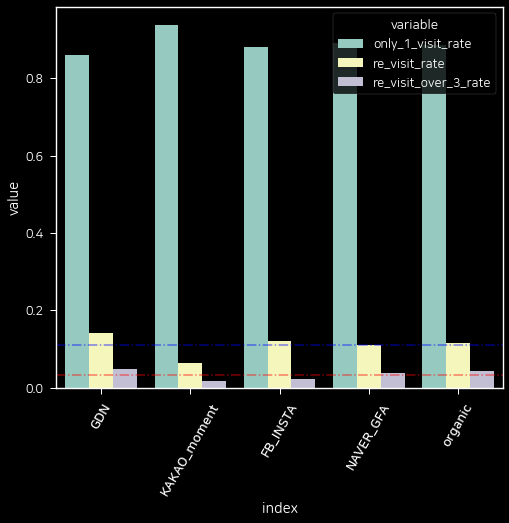

In [125]:
#------------------------------------------------#
## 2. 재방문율
#------------------------------------------------#
### 1) 1회 / 2회 이상 / 3회 이상 방문자
dict_output_revisit = dict()

#### count revisit rate
def revisit_rate(dict_input, dict_output):
    for _referrer, _segment in dict_input.items():
        dict_output[_referrer] = dict()
        _df_user_day_cnt = df_app_log[df_app_log[KEY_ID_DEVICE].isin(_segment)].groupby(KEY_ID_DEVICE)['day'].count()

        only_1_visit_rate = round(_df_user_day_cnt.value_counts()[1] / len(_segment), 4)
        re_visit_rate = round(1 - only_1_visit_rate, 4)
        re_visit_over_3_rate = round(1 - _df_user_day_cnt.value_counts()[:2].sum() / len(_segment), 4)
        
        dict_output[_referrer]['only_1_visit_rate'] = only_1_visit_rate
        dict_output[_referrer]['re_visit_rate'] = re_visit_rate
        dict_output[_referrer]['re_visit_over_3_rate'] = re_visit_over_3_rate

    _df_output = pd.DataFrame.from_dict(
        dict_output, orient = 'index'
        ).sort_values(by = 're_visit_rate', ascending=False).reset_index()
    
    return _df_output

df_ouput_revisit = revisit_rate(dict_lst_user_from_referrs_gudok, dict_output_revisit)
df_ouput_revisit

#### prep for vis
df_vis_1_2_retention = pd.DataFrame.from_dict(
    dict_output_revisit, orient = 'index'
    ).reset_index().melt(id_vars='index')
avg_rate_re_visit_over_2 = df_vis_1_2_retention[
    df_vis_1_2_retention['variable'] == 're_visit_rate'].mean().value
avg_rate_re_visit_over_3 = df_vis_1_2_retention[
    df_vis_1_2_retention['variable'] == 're_visit_over_3_rate'].mean().value

#### vis
ax = sns.barplot(
    data = df_vis_1_2_retention.reset_index(),
    x = 'index', y = 'value',
    capsize = 2 , alpha = 1, hue = 'variable'
    )
_ = plt.xticks(rotation=60, fontproperties = fprop)
_ = plt.axhline(y=avg_rate_re_visit_over_2, color='blue', ls = '-.', alpha = 0.5, label = 'a')
_ = plt.axhline(y=avg_rate_re_visit_over_3, color='red', ls = '-.', alpha = 0.5, label = 'a')
plt.show()

### (3)구독전환
- 구독전환수
- 구독전환율

In [134]:
#########################################
# 1. 구독완료
## 1) 일별 구독완료 유저 수
## 2) 구독전환율
#########################################
dict_output_subscribe = {}
df_daily_subscribe = pd.DataFrame()
df_subscribe_conversion = pd.DataFrame(index=[
                                'landing_cnt', 
                                'subscribe_cnt', 
                                'subscribe_conversion'])

def count_subscribe_conversion(dict_input, dict_output, df_output_daily, df_output_conversion, KEY_ID = KEY_ID_DEVICE):
    _df_log_target = df_app_log_total[
        df_app_log_total['abs_events'].apply(
            lambda x : True if EVENT_SUBSCRIBE in x else False
            )]

    df_output = _df_log_target.groupby('day')[KEY_ID].nunique().to_frame(name = 'total_cnt')
    _lst_device = list(_df_log_target[KEY_ID].unique())

    for _referrer, _segment in dict_input.items():
        ### 2) 매체별 일별 구독완료 유저 수
        _lst_target = list(set(_lst_device) &  set(_segment))

        _df = _df_log_target[_df_log_target[KEY_ID].isin(_segment)].groupby('day')[KEY_ID].nunique().to_frame(name = f'{_referrer}_subscribe_cnt').fillna(0)

        dict_output_subscribe[f'{_referrer}'] = {}
        dict_output_subscribe[f'{_referrer}']['subscribe_cnt'] = _df
        df_output[f'{_referrer}'] = _df[f'{_referrer}_subscribe_cnt']
        df_output.fillna(0, inplace=True)

        ### 3) 구독전환율
        landing_cnt = len(_segment)
        _df = df_param_subscribe[df_param_subscribe[KEY_ID_DEVICE].isin(_segment)]
        subscribe_cnt = _df[KEY_ID_DEVICE].nunique()
        dict_output[f'{_referrer}']['subscribe_conversion'] = [landing_cnt,
                                                        subscribe_cnt, 
                                                        (subscribe_cnt/landing_cnt)]

        df_output_conversion[f'{_referrer}'] = dict_output[f'{_referrer}']['subscribe_conversion']
        
    return df_output, df_output_conversion

df_daily_subscribe, df_subscribe_conversion =count_subscribe_conversion(
                                                dict_lst_user_from_referrs_gudok, dict_output_subscribe, 
                                                df_daily_subscribe, df_subscribe_conversion)

pd.set_option('max_rows', 100)
df_daily_subscribe
df_subscribe_conversion

,total_cnt,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
day,,,,,,
2022-10-01,75,0.0,0.0,0.0,0.0,75
2022-10-02,66,0.0,0.0,0.0,0.0,66
2022-10-03,57,0.0,0.0,0.0,0.0,57
2022-10-04,67,0.0,0.0,0.0,0.0,66
2022-10-05,68,0.0,0.0,0.0,0.0,63
2022-10-06,72,0.0,0.0,0.0,0.0,71
2022-10-07,99,0.0,0.0,0.0,0.0,99
2022-10-08,45,0.0,0.0,0.0,0.0,45
2022-10-09,61,0.0,0.0,0.0,0.0,61


,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
landing_cnt,12403.000000,7152.00000,8391.000000,11473.000000,2.150585e+06
subscribe_cnt,6.000000,2.00000,119.000000,46.000000,1.937000e+03
subscribe_conversion,0.000484,0.00028,0.014182,0.004009,9.006852e-04


### (4)Fraud
- 바운스율
- 정착율

In [135]:
#########################################
# 1. 바운스 유저 비율 & 정착 유저 비율
#########################################
dict_fraud_referrs = {}

def count_fraud(dict_input, dict_output, lst_fraud = lst_fraud_device):
    for _referrer, _segment in dict_lst_user_from_referrs_gudok.items():
        _lst_device= list(set(_segment) & set(lst_fraud))       ## 수정된 부분
        
        total_cnt = len(_segment)
        fraud_cnt = len(_lst_device)
        fraud_rate = fraud_cnt / total_cnt
        settle_rate = 1 - fraud_rate                                

        dict_output[f'{_referrer}'] = [total_cnt, fraud_cnt, fraud_rate, settle_rate]

    _df_output = pd.DataFrame.from_dict(
        dict_output, orient='index', columns=[
            'total_cnt', 'fraud_cnt', 'fraud_rate', 'settle_rate'])
    
    return _df_output, dict_output

df_fraud_referrs, dict_fraud_referrs = count_fraud(dict_lst_user_from_referrs_gudok, dict_fraud_referrs)
df_fraud_referrs

,total_cnt,fraud_cnt,fraud_rate,settle_rate
GDN,12403,9945,0.801822,0.198178
KAKAO_moment,7152,6667,0.932187,0.067813
FB_INSTA,8391,7121,0.848647,0.151353
NAVER_GFA,11473,10179,0.887213,0.112787
organic,2150585,1569844,0.729961,0.270039


### (5)앱설치 유저

In [43]:
# df_app_log[df_app_log[KEY_ID_USER].apply(lambda x:True if ',Y' in x else False)]

In [39]:
# #########################################
# 0. prep
# #########################################
df_prop = SpherePrep.Prop.df_prop_pipe(
                df_app_log, [KEY_ID_DEVICE, KEY_ID_USER], 
                drop_none_prop = False)

EVENT_APP_INSTALL = '#appInstall'
app_key_android = 'qsJfZhE2Ft85SvZoXInoo3'
app_key_ios = 'qsJfZhE2Ft85SvZTOvxsUA'

#########################################
# 1. 앱설치 유저
#########################################
dict_install = {}

def count_app_install(dict_input, dict_output):
    _df_log_install = df_app_log[df_app_log['abs_events'].apply(lambda x : True if EVENT_APP_INSTALL in x else False)]

    for _referrer, _segment in dict_input.items():
        ## 1) 캠페인 유저의 사용자 ID 추출
        _lst_campaign_user_id = list(set(df_prop[df_prop[KEY_ID_DEVICE].isin(_segment)][KEY_ID_USER]))
        
        ## 2) 캠페인 유저의 사용자 ID중 android & ios 앱 사용자
        dict_output[f'{_referrer}'] = {}
        _lst_campaign_user_ids =\
            list(
                df_app_log[
                (df_app_log['app_key'].isin([app_key_android, app_key_ios])) & 
                (df_app_log[KEY_ID_USER].isin(_lst_campaign_user_id))
                ][KEY_ID_USER].unique()
                )
            # _df_log_install[_df_log_install[KEY_ID_USER].isin(_lst_user_id)][KEY_ID_USER]

        dict_output[f'{_referrer}'] = len(_lst_campaign_user_ids)

    df_output = pd.DataFrame.from_dict(
                    dict_output, orient='index', columns= ['install_cnt'])

    return df_output, dict_output

df_install_referrs, dict_install = count_app_install(dict_lst_user_from_referrs_gudok, dict_install)
df_install_referrs

,install_cnt
GDN,6
KAKAO_moment,2
FB_INSTA,57
NAVER_GFA,20
organic,7944


In [16]:
# # 2. gender & age_group 
# ## KAKAO_moment: drop (설치자 0명이라서)
# dict_lst_user_from_referrs_gudok_demo = dict_lst_user_from_referrs_gudok
# del dict_lst_user_from_referrs_gudok_demo['KAKAO_moment']

# ## 시각화
# Profiling.demo_profiling( 
#     df_user_prop=df_prop, KEY_ID=KEY_ID_DEVICE, 
#     dict_user_list=dict_lst_user_from_referrs_gudok_demo, 
#     total_avg = True, vis_type = 'all')

In [45]:
# ## exact numbers age/gender by referrs
# _df_gender = pd.DataFrame()
# _df_age = pd.DataFrame()

# for key, lst_id in dict_lst_user_from_referrs_gudok_demo.items():
#     if key != 'total':
#         _df = df_prop[df_prop[KEY_ID_DEVICE].isin(lst_id)]
#         _df_gender = pd.concat(
#             [_df_gender, _df['gender'].value_counts().to_frame(name = f'{key}_gender')], axis=1).fillna(0)
#         _df_age = pd.concat(
#             [_df_age, _df['age_group'].value_counts().to_frame(name = f'{key}_age')], axis=1).fillna(0)
#     else:
#         pass

# _df_gender
# _df_age

### (6)활성
- 인당 체류 시간
- 인당 컨텐츠 조회수
- 검색 조회 빈도

In [151]:
#########################################
# 1. 인당 체류시간
#########################################
dict_duration = {}
dict_events_cnt_output = {}

def activation(dict_input, dict_ouput1, dict_output2, KEY_ID = KEY_ID_DEVICE):
    lst_device_no_fraud = list(set(lst_total_device) - set(lst_fraud_device))
    _df_log_no_fraud = df_app_log[df_app_log[KEY_ID].isin(lst_device_no_fraud)]

    for _referrer, _segment in dict_input.items():
        ## 1) 평균 체류 시간
        _df = _df_log_no_fraud[_df_log_no_fraud[KEY_ID_DEVICE].isin(_segment)]
        dict_ouput1[f'{_referrer}']= _df.groupby(KEY_ID)['duration'].sum().mean()

        ## 2) 평균 컨텐츠 조회수
        _df_app_log_by_referr = df_app_log[
                                    df_app_log[KEY_ID_DEVICE].isin(_segment)]
        _df_app_log_by_referr['events_cnt'] = _df_app_log_by_referr['abs_events'].apply(lambda x : len(x))

        dict_output2[f'{_referrer}'] = _df_app_log_by_referr.groupby(KEY_ID_DEVICE)['events_cnt'].sum().mean()

    ### 1-2) 평균 체류 시간 df화
    _df_output1 = pd.DataFrame.from_dict(dict_ouput1, orient='index', columns=['average_duration'])
    _df_output1 = _df_output1.sort_values(by = 'average_duration', ascending=False)

    ### 2-2) 평균 컨텐츠 조회수 df화
    _df_output2 = pd.DataFrame.from_dict(dict_output2, orient='index',  columns=['average_event_cnt'])

    return _df_output1, _df_output2

df_duration, df_event_cnt = activation(dict_lst_user_from_referrs_gudok, dict_duration, dict_events_cnt_output)
df_duration
df_event_cnt

,average_duration
GDN,392.043053
KAKAO_moment,327.877412
NAVER_GFA,292.743944
organic,283.400247
FB_INSTA,128.213900


,average_event_cnt
GDN,1.625816
KAKAO_moment,1.244407
FB_INSTA,1.992015
NAVER_GFA,2.017955
organic,3.538124


In [88]:
# #########################################
# # 2. 인당 컨텐츠 조회수
# #########################################
# ## 3) 전체 컨텐츠 인당 일별 조회 수
# ### (1) 랜딩 페이지 접속 유저
# #### 이상 유저 제거 x
# print('인당 전체 컨텐츠 조회수')
# cal_event_cnt_per_device_ver2(_df_log_target_letter,
#         '랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함): ')

# #### 이상 유저 제거 o
# cal_event_cnt_per_device_ver2(_df_log_target_no_fraud,
#         '랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거): ')


# ### (2) 랜딩 페이지 접속 x 유저
# #### 이상 유저 제거 x
# lst_not_landing_device = set(lst_total_device) - set(lst_landing_device)
# _df_log_target3 = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_not_landing_device)]
# cal_event_cnt_per_device_ver2(_df_log_target3,
#         '랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함): ')


# #### 이상 유저 제거 o
# _df_log_target_no_fraud3 =\
#         _df_log_target3[_df_log_target3[KEY_ID_DEVICE].isin(lst_device_no_fraud)]
# cal_event_cnt_per_device_ver2(_df_log_target_no_fraud3,
#         '랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거): ')

In [89]:
# #########################################
# # 3. 인당 검색 조회 빈도
# #########################################
# ## 1) 랜딩페이지 접속 유저
# ### 이상 유저 포함
# _df_log_target_letter = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_landing_device)]

# dict_search = {}
# for key, values in dict_lst_user_from_referrs_gudok.items():
#     _df = _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(values)]
#     _df['search_cnt'] = _df['abs_events'].apply(lambda x: Counter(x)[EVENT_SEARCH] if EVENT_SEARCH in x else 0)
#     dict_search[f'{key}_이상 유저 포함'] = _df.groupby([KEY_ID_DEVICE, 'day'])['search_cnt'].count().mean()
#     print(f'{key} 인당 검색 조회 빈도(이상 유저 포함): ', round(dict_search[f'{key}_이상 유저 포함'], 2), '회')

# print('-'*50)

# ### 이상 유저 제거 --> 차이 없음!
# _df_log_target_no_fraud =\
#      _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(lst_device_no_fraud)]

# for key, values in dict_lst_user_from_referrs_gudok.items():
#     _df = _df_log_target_no_fraud[_df_log_target_no_fraud[KEY_ID_DEVICE].isin(values)]
#     _df['search_cnt'] = _df['abs_events'].apply(lambda x: Counter(x)[EVENT_SEARCH] if EVENT_SEARCH in x else 0)
#     dict_search[f'{key}_이상 유저 제거'] = _df.groupby([KEY_ID_DEVICE, 'day'])['search_cnt'].count().mean()
#     print(f'{key} 인당 검색 조회 빈도(이상 유저 제거): ', round(dict_search[f'{key}_이상 유저 제거'] , 2), '회')

## 2)이동경로
- 구독 완료자
    - 광고 유입
    - 자연 유입
- 구독 미완료자
    - 광고 유입
    - 자연 유입

In [11]:
# #########################################
# 0. user segment setting
# #########################################
## 1) user segment setting
### (1) 참가 device
lst_campaign_device = list(df_app_log[df_app_log['referrer_utm_campaign'] == '2022_gudok'][KEY_ID_DEVICE].unique())
lst_campaign_subscribe_o = list(set(lst_campaign_device) & set(lst_subscribe_device))
lst_campaign_subscribe_x = list(set(lst_campaign_device) - set(lst_campaign_subscribe_o))

### (2) 미참가 device

## 2) event parameter 수정


In [22]:
# #########################################
# 1. 구독 완료자 이동 경로
# #########################################
## 0) cdj run function
def run_cdj(df_target, KPI_event, impurity=0.3, jaccard_score = 0.7, n_max_unique = 2) :
    ## total kpi count
    total_raw_kpi = sum(df_target.events.apply(lambda x : AnomalyDetection.check_event(x, KPI_event)))

    ## data anomaly detection
    train = AnomalyDetection.date_anomaly_detection(df_target, 'date')

    ## cdj_main
    output = CDJ_main.cdj_main(
                train, KPI_event, impurity=impurity,\
                jaccard_score = jaccard_score, n_max_unique = 2) 
                
    ## return output
    return output, total_raw_kpi

## 1) 광고 유입 유저 이동 경로
### data setting
_df_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_campaign_subscribe_o)]
_df_output1, total_subscribe = run_cdj(_df_target, EVENT_SUBSCRIBE, impurity=0.5, jaccard_score=0.9)
total_subscribe
_df_output1

# ## 2) 자연 유입 유저 이동 경로
# lst_campaign_x_subscribe_o = 
# _df_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_campaign_x_subscribe_o)]
# _df_output1, total_subscribe = run_cdj(_df_target, EVENT_SUBSCRIBE, impurity=0.5, jaccard_score=0.9)
# _df_output1

94

,final_cdj_path,cnt,ratio
0,"[sapHome, searchMain, sapContentDetail, subscr...",3,33.33


['sapHome',
 'searchMain',
 'sapContentDetail',
 'subscribeClicsapContentShare',
 'sapLogin',
 'sapContentDetail',
 'subscribeClicsapContentShare',
 'subscribe']

In [27]:
# for _lst_target in [lst_campaign_subscribe_x, lst_campaign_subscribe_o] :
lst_target = lst_campaign_subscribe_o
### (2) session data frame
_, df_param_campagin_session = DataImport.json_to_dataframe_nodeN( 
    df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_target)], 
    [KEY_ID_DEVICE, KEY_ID_USER, 'sid']
    ) ### + param by session
df_param_campagin_session['date'] = pd.to_datetime(df_param_campagin_session['date'], format='%Y%m%d %H:%M:%S')
df_param_campagin_session['date_hm'] = df_param_campagin_session['date'].apply(lambda x : x.strftime('%y-%m-%d %H:%M'))

### 2) 가볼래터 이벤트명 변경 data 생성
df_param_contents_letter =\
     df_param_campagin_session[
        (df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False)) | 
        (df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('구독', na=False))
        ]
### 구독 이벤트명 변경
df_param_contents_letter['name'] =  df_param_contents_letter[PARAM_CONTENT_NAME]

df_param_contents_except_letter =\
     df_param_campagin_session[
        ~(df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False) ) &
        ~(df_param_campagin_session[PARAM_CONTENT_NAME].str.contains('구독', na=False) )
        ]

df_param_campagin_session_letter = pd.concat([
    df_param_contents_letter,
    df_param_contents_except_letter
])

df_param_campagin_session_letter = df_param_campagin_session_letter.sort_values(by = ['sid', 'date'])
df_param_campagin_session_letter = df_param_campagin_session_letter.drop_duplicates(['sid', 'date_hm', 'name'], keep='first') # 동일 분 안에 중복 이벤트 제거

In [47]:
# make sequance data
dict_journey_subset_to_kpi = {}
dict_journey_subset_after_kpi = {}
dict_journey_subset_churn = {}

for _key_id in df_param_campagin_session_letter[KEY_ID_DEVICE].unique()[:3000] : 
    _df_journey_subset = df_param_campagin_session_letter[df_param_campagin_session_letter[KEY_ID_DEVICE] == _key_id].reset_index(drop = True)
    ## 구독 완료 유저
    if '구독신청 완료!' in _df_journey_subset[PARAM_CONTENT_NAME].unique() :
        kpi_index = _df_journey_subset[_df_journey_subset[PARAM_CONTENT_NAME] == '구독신청 완료!'].index[0]
        _df_journey_subset_to_kpi = _df_journey_subset.iloc[:kpi_index+1]
        _df_journey_subset_after_kpi = _df_journey_subset.iloc[kpi_index+1:]
        try : _dict_journey_subset_to_kpi = _df_journey_subset_to_kpi[['name']].T.to_dict(orient = 'records')[0]
        except : pass
        try : _dict_journey_subset_after_kpi = _df_journey_subset_after_kpi[['name']].T.to_dict(orient = 'records')[0]
        except : pass

        for i, _event in _dict_journey_subset_to_kpi.items() :
            if i not in dict_journey_subset_to_kpi.keys() :
                dict_journey_subset_to_kpi[i] = [_event]
            else :
                dict_journey_subset_to_kpi[i] = dict_journey_subset_to_kpi[i] + [_event]





    ## 구독 미완료 유저
    else :
        _df_journey_subset = _df_journey_subset[['name']]
        ## 이탈 이벤트 생성
        _df_journey_subset_churn = pd.concat([_df_journey_subset, pd.DataFrame(['이탈'], columns=  ['name'])]).reset_index(drop = True)     
        try : _df_journey_subset_churn = _df_journey_subset_churn.T.to_dict(orient = 'records')[0]
        except : pass

        for i, _event in _df_journey_subset_churn.items() :
            if i not in dict_journey_subset_churn.keys() :
                dict_journey_subset_churn[i] = [_event]
            else :
                dict_journey_subset_churn[i] = dict_journey_subset_churn[i] + [_event]



# output
for i in range(5) : 
    df_seq_kpi = pd.DataFrame.from_dict(Counter(dict_journey_subset_to_kpi[i]), orient='index', columns=['cnt'])
    df_seq_kpi['percent'] = round(df_seq_kpi['cnt'] / df_seq_kpi['cnt'].sum() * 100, 2)
    df_seq_kpi = df_seq_kpi.rename(columns={'cnt' : f'{i+1} step'})
    df_seq_kpi.head(3)

# # output
# for i in range(5) : 
#     df_seq_churn = pd.DataFrame.from_dict(Counter(dict_journey_subset_churn[i]), orient='index', columns=['cnt'])
#     df_seq_churn['percent'] = round(df_seq_churn['cnt'] / df_seq_churn['cnt'].sum() * 100, 2)
#     df_seq_churn = df_seq_churn.rename(columns={'cnt' : f'{i+1} step'})
#     df_seq_churn.head(3)

,1 step,percent
가볼래-터 구독하러 가기,170,75.22
balanceGameMain,33,14.60
sapContentDetail,10,4.42


,2 step,percent
지금 바로 구독하기,91,40.27
가볼래-터 구독하러 가기,39,17.26
balanceGame,24,10.62


,3 step,percent
sapLogin,80,35.40
가볼래-터 구독하러 가기,74,32.74
travelLetterLike,1,0.44


,4 step,percent
가볼래-터 구독하러 가기,89,39.56
sapLogin,47,20.89
sapContentDetail,2,0.89


,5 step,percent
지금 바로 구독하기,58,26.98
구독신청 완료!,23,10.70
가볼래-터 구독하러 가기,42,19.53


In [94]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
## 1) data setting
### 가볼래터 한정 contentdetail -> contentletter로 데이터 값 정정
df_param_contents_letter['name'] = df_param_contents_letter['name'].apply(
    lambda x : 'sapContentDetail' if x == 'sapContentDetail' else x)\
        .replace({'sapContentDetail':'sapContentLetterDetail'})

### 두 df 차집합 구하고 한 테이블로 셋팅
_df_diff = pd.concat([df_param_all_session, df_param_contents_letter, df_param_contents_letter]).drop_duplicates(keep=False)
df_param_all_prep = pd.concat([_df_diff, df_param_contents_letter], axis = 0).drop_duplicates(keep='first')

### 세그먼트 데이터 생성
df_param_all_referrs = df_param_all_prep[df_param_all_prep[KEY_ID_DEVICE].isin(lst_landing_device)]
df_param_all_referrs.sort_values(by = 'date').groupby([KEY_ID_DEVICE, 'sid', 'date_ymd']).head()
print('-'*70)

### 10월 이전 데이터 확인
print('10월 이전 데이터 수: ', df_param_all_referrs[df_param_all_referrs['date'] < '2022-10-01 00:00:00'].shape[0])
print('-'*70)

### 10월 이전 데이터 제거 후 확인
df_param_all_referrs =\
    df_param_all_referrs[
        df_param_all_referrs['date'] >=\
             '2022-10-01 00:00:00']

df_param_all_referrs.sort_values(by = 'date', ascending=True).head(3)

In [50]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
## 전처리를 위한 구분자 추가
df_param_all_referrs['name'] = \
     df_param_all_referrs['name'].apply(lambda x : x + '-')

df_user_referrs_event = \
    df_param_all_referrs.groupby('sid')['name'].sum()\
    .to_frame(name = 'event_name').reset_index()
 
## target user 그룹 생성
dict_destination_referrs = {}
_lst = []

for i in range(len(df_user_referrs_event)):
    if 'subscribe-' in df_user_referrs_event.iloc[i]['event_name']:
        _lst.append(df_user_referrs_event.iloc[i]['sid'])

dict_destination_referrs['subscribe'] = {}
dict_destination_referrs['subscribe']['sid']= list(set(_lst))

## target user의 가장 흔한 이동 경로
_df_target_journey =\
    df_user_referrs_event[
        df_user_referrs_event['sid'].isin(dict_destination_referrs['subscribe']['sid'])]

_df_target_journey
print('-'*70)

_df_target_journey2 = _df_target_journey.copy()             # 백업용 데이터 생성

## 경로가 몇 번 겹치는지 확인
_df_cnt = _df_target_journey['event_name'].value_counts().to_frame(name = 'cnt').reset_index()
_df_cnt['cnt'].value_counts()

,sid,event_name
4,--8HJ3jSENV6D87DPRzsRK,sapHome-themeTravelMain-searchMain-searchMain-...
79,-21cOeXKR1aspVGxdItgEA,sapHome-searchMain-sapContentDetail-subscribeC...
151,-4hcwfOeXAxEh_zHuJrjT8,sapContentDetail-sapContentDetail-sapContentDe...
203,-6kkHjiB0sRsOCyQ8u2LGZ,sapHome-searchMain-searchMain-searchMain-searc...
219,-7ZLP100rrTrx0qotcnHQB,sapLogin-sapContentDetail-sapLogout-sapContent...
...,...,...
120296,zpFmOXYsT-KDy8peBGfqSQ,sapHome-searchMain-balanceGameMain-balanceGame...
120315,zpsAV3544dZBLdQ8RPGeS0,sapHome-searchMain-searchMain-searchMain-drawe...
120320,zq5T6GD2xfSiDZvWCNaGJO,sapHome-themeTravelMain-searchMain-searchMain-...
120428,zuBMOwS90zacMbMVqUlcam,sapContentDetail-sapContentDetail-sapContentDe...


----------------------------------------------------------------------


1    2073
2      14
3       5
7       1
8       1
4       1
Name: cnt, dtype: int64

In [1]:
#########################################
# 1. 광고 유입
# ** 시작점: 랜딩 페이지
# ** 도착점: subscribe 이벤트
#########################################
## 구분자 -로 event_name 값 리스트 형태로 정정
for i in range(len(_df_target_journey)):
    _df_target_journey2.iloc[i]['event_name'] = _df_target_journey.iloc[i]['event_name'].split('-')

_df_target_journey2

## value_counts == 1인 경로 간 유사도 구하기
_df_cnt_1 = _df_cnt[_df_cnt['cnt'] == 1].reset_index(drop=True)
_lst_remove_index = []
_lst_target=list(_df_cnt_1['index'].unique())

## 임계점이 0.5일 때 각기 다른 이동 경로 수가 2051개로 나옴 = 즉 유사도가 필터링해낸 경로(=같다고 본 경로)가 하나도 없다는 뜻 
## 따라서 임계점을 0.3으로 두고 진행해봄 -> 그러나 결과 same.....
i=0
while i < len(_df_cnt_1):
    x = i+1
    while x < len(_df_cnt_1):
        answer_string = _df_cnt_1.iloc[i]['index']
        input_string = _df_cnt_1.iloc[x]['index']

        intersection_cardinality = len(set.intersection(*[set(answer_string), set(input_string)]))
        union_cardinality = len(set.union(*[set(answer_string), set(input_string)]))
        similar = intersection_cardinality / float(union_cardinality)

        if similar > 0.1:
            _lst_remove_index.extend([i])        
            _lst_target = list(set(_lst_target) - set(answer_string))
        else:
            pass
        
        x+=1
    i+=1

_lst_remove_index = list(set(_lst_remove_index))
print('이동 경로 수: ',len(_lst_target))           